In [1]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import Dense,BatchNormalization,Conv1D
from keras.layers import Input,GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.optimizers import Adam
from utils import generate, generate_sim, OrnsteinUng
import tensorflow as tf
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
import datetime
from keras.callbacks import History 
import matplotlib.pyplot as plt
import pickle
import glob
import os

Using TensorFlow backend.


Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 19, 1)        0                                            
__________________________________________________________________________________________________
conv1d_248 (Conv1D)             (None, 19, 32)       96          input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_251 (Conv1D)             (None, 19, 32)       96          input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_254 (Conv1D)             (None, 19, 32)       128         input_14[0][0]                   
___________________________________________________________________________________________

Epoch 1/25
50/50 [==============================] - 25s 495ms/step - loss: 1.3381 - acc: 0.3375 - val_loss: 1.1341 - val_acc: 0.3212
Epoch 2/25
50/50 [==============================] - 29s 586ms/step - loss: 1.0432 - acc: 0.4769 - val_loss: 1.1165 - val_acc: 0.4412
Epoch 3/25
50/50 [==============================] - 13s 260ms/step - loss: 0.9671 - acc: 0.5231 - val_loss: 0.8927 - val_acc: 0.5263
Epoch 4/25
50/50 [==============================] - 9s 185ms/step - loss: 0.9160 - acc: 0.5487 - val_loss: 0.8764 - val_acc: 0.5500
Epoch 5/25
50/50 [==============================] - 9s 179ms/step - loss: 0.8660 - acc: 0.5863 - val_loss: 0.8887 - val_acc: 0.5825
Epoch 6/25
50/50 [==============================] - 8s 160ms/step - loss: 0.8382 - acc: 0.5975 - val_loss: 0.8186 - val_acc: 0.6300
Epoch 7/25
50/50 [==============================] - 8s 152ms/step - loss: 0.7948 - acc: 0.6456 - val_loss: 0.7009 - val_acc: 0.6725
Epoch 8/25
50/50 [==============================] - 8s 153ms/step - loss:

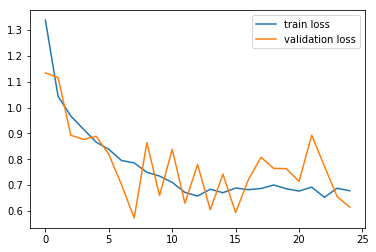

In [10]:
history = History()

batchsize = 32
T = np.arange(19,21,0.1) # this provides another layer of stochasticity to make the network more robust
steps = 20
 # number of steps to generate
initializer = 'he_normal'
f = 32 #number of filters
sigma = 0 #noise variance

inputs = Input((steps-1,1))

x1 = Conv1D(f,2,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv1D(f,2,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(f,2,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = BatchNormalization()(x1)
x1 = GlobalMaxPooling1D()(x1)


x2 = Conv1D(f,2,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x2 = BatchNormalization()(x2)
x2 = Conv1D(f,2,dilation_rate=3,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = BatchNormalization()(x2)
x2 = Conv1D(f,2,dilation_rate=5,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = BatchNormalization()(x2)
x2 = GlobalMaxPooling1D()(x2)


x3 = Conv1D(f,3,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x3 = BatchNormalization()(x3)
x3 = Conv1D(f,3,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = BatchNormalization()(x3)
x3 = Conv1D(f,3,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = BatchNormalization()(x3)
x3 = GlobalMaxPooling1D()(x3)


x4 = Conv1D(f,3,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x4 = BatchNormalization()(x4)
x4 = Conv1D(f,3,dilation_rate=3,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = BatchNormalization()(x4)
x4 = Conv1D(f,3,dilation_rate=5,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = BatchNormalization()(x4)
x4 = GlobalMaxPooling1D()(x4)


x5 = Conv1D(f,4,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x5 = BatchNormalization()(x5)
x5 = Conv1D(f,4,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x5)
x5 = BatchNormalization()(x5)
x5 = Conv1D(f,4,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x5)
x5 = BatchNormalization()(x5)
x5 = GlobalMaxPooling1D()(x5)

x7 = Conv1D(f,4,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x7 = BatchNormalization()(x7)
x7 = Conv1D(f,4,dilation_rate=3,padding='causal',activation='relu',kernel_initializer=initializer)(x7)
x7 = BatchNormalization()(x7)
x7 = Conv1D(f,4,dilation_rate=5,padding='causal',activation='relu',kernel_initializer=initializer)(x7)
x7 = BatchNormalization()(x7)
x7 = GlobalMaxPooling1D()(x7)


x6 = Conv1D(f,7,padding='same',activation='relu',kernel_initializer=initializer)(inputs)
x6 = BatchNormalization()(x6)
x6 = GlobalMaxPooling1D()(x6)


con = concatenate([x1,x2,x3,x4,x5,x6])
dense = Dense(512,activation='relu')(con)
# dense = Dense(256,activation='relu')(dense)
dense = Dense(128,activation='relu')(dense)
# dense = Dense(64,activation='relu')(dense)
# dense = Dense(32,activation='relu')(dense)
dense2 = Dense(3,activation='softmax')(dense)
model = Model(inputs=inputs, outputs=dense2)

optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['acc'])
model.summary()


callbacks = [
         ReduceLROnPlateau(monitor='val_loss',
                           factor=0.1,
                           patience=4,
                           verbose=1,
                           min_lr=1e-9),
         ModelCheckpoint(filepath=f'./Models/{steps}_model.h5',
                         monitor='val_acc',
                         save_best_only=False,
                         mode='max',
                         save_weights_only=False), history]


gen = generate(batchsize=batchsize,steps=steps,T=T,sigma=sigma)
model.fit_generator(generator=gen,
        steps_per_epoch=50,
        epochs=25,
        verbose=1,
        callbacks=callbacks,
        validation_data=generate(batchsize=batchsize,steps=steps,T=T,sigma=sigma),
        validation_steps=25)


train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['acc']
val_acc    = history.history['val_acc']
xc         = range(25)


##https://stackoverflow.com/questions/11026959/writing-a-dict-to-txt-file-and-reading-it-back
with open(f'maxpoolingtwodense/{steps}_history.txt', 'wb') as handle:
    pickle.dump(history.history, handle)

plt.figure()
plt.plot(xc, train_loss, label="train loss")
plt.plot(xc, val_loss, label="validation loss")
plt.legend()
plt.savefig(f"maxpoolingtwodense/{steps}_loss.png")

[(10, 0.668749988079071), (15, 0.7281249761581421), (20, 0.7562500238418579), (29, 0.8087499737739563), (30, 0.800000011920929), (31, 0.78125), (32, 0.793749988079071), (33, 0.796875), (34, 0.800000011920929), (35, 0.8125), (36, 0.8199999928474426), (38, 0.8212500214576721), (39, 0.8299999833106995), (40, 0.8343750238418579), (49, 0.831250011920929), (50, 0.8218749761581421), (51, 0.84375), (52, 0.8450000286102295), (53, 0.8037499785423279), (60, 0.862500011920929), (70, 0.815625011920929), (80, 0.8812500238418579), (90, 0.878125011920929), (100, 0.859375), (300, 0.940625011920929)]
[10, 15, 20, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 49, 50, 51, 52, 53, 60, 70, 80, 90, 100, 300]
[0.668749988079071, 0.7281249761581421, 0.7562500238418579, 0.8087499737739563, 0.800000011920929, 0.78125, 0.793749988079071, 0.796875, 0.800000011920929, 0.8125, 0.8199999928474426, 0.8212500214576721, 0.8299999833106995, 0.8343750238418579, 0.831250011920929, 0.8218749761581421, 0.84375, 0.8450000286102

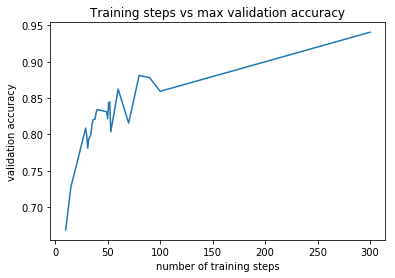

In [3]:
plt.figure()
sizes = []
max_val_acc = []

dir_path = os.getcwd() + "added_layers"
matching_files = glob.glob( dir_path +"\*_history*")

for file in matching_files:
    with open(file, 'rb') as handle:
        history = pickle.loads(handle.read())
        train_loss = history['loss']
        val_loss   = history['val_loss']
        train_acc  = history['acc']
        val_acc    = history['val_acc']
        
        max_val_acc.append(max(val_acc))
    string = [s for s in file if s.isdigit()]
    actualstring = ""
    for s in string:
        actualstring += s
    sizes.append(int(actualstring))
zipped = zip(sizes, max_val_acc)
sorted_pairs = sorted(zipped)
sizes = [sorted_pairs[i][0] for i in range(len(sorted_pairs))]
max_val_acc = [sorted_pairs[i][1] for i in range(len(sorted_pairs))]

print(sorted_pairs)
print(sizes)
print(max_val_acc)
plt.xlabel("number of training steps")
plt.ylabel("validation accuracy")
plt.title("Training steps vs max validation accuracy")
plt.plot(sizes, max_val_acc)

#         plt.plot(xc, val_loss, label="validation loss")
#         plt.legend()

In [22]:
def classification_on_sim(net_file, num_steps):
    dx,label=generate_sim(batchsize=100,steps=num_steps,T=15,sigma=0.00)
    ### change here to load a different network model
    print(dx)
    N=np.shape(dx)[0]
#     net_file = './Models/model_testsigma0-wB-6layern-300-variance-FBMCTRW.h5'
    model = load_model(net_file)
    predictions = []
    for j in range(N):
        dummy = np.zeros((1,num_steps-1,1))
        dummy[0,:,:] = dx[j,:,:]
        y_pred = model.predict(dummy) # get the results for 1D 
        print(y_pred)
        ymean = np.mean(y_pred,axis=0) # calculate mean prediction of N-dimensional trajectory 
        prediction = np.argmax(ymean,axis=0) # translate to classification
        predictions.append(prediction)

    accuracy = 100 * np.sum([1 if label[i] == predictions[i] else 0 for i in range(len(label))]) / len(label)
    return accuracy


In [23]:
accuracies = []
# for i in range(10, 101, 10):
accuracies.append(classification_on_sim('./Models/300_model.h5', 300))
print(accuracies)

[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.10077603]
  [ 1.01492113]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[-2.33335373]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 ...

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[-0.3988092 ]
  [ 0.40503002]
  [-0.43279118]
  ...
  [ 0.27990043]
  [-0.27671639]
  [ 0.50046888]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]]
[[0.18749148 0.33819774 0.47431076]]
[[0.00462613 0.02028624 0.97508764]]
[[0.00185184 0.00700784 0.9911403 ]]
[[0.18749148 0.33819774 0.47431076]]
[[0.43998116 0.52153945 0.03847945]]
[[0.18749148 0.33819774 0.47431076]]
[[0.52524626 0.42791384 0.04683989]]
[[0.40487963 0.39813885 0.19698149]]
[[0.18749148 0.33819774 0.47431076]]
[[0.3541185  0.51471114 0.13117042]]


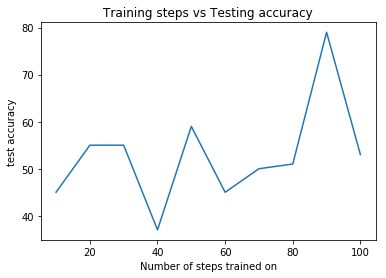

In [9]:
plt.xlabel("Number of steps trained on")
plt.ylabel("test accuracy")
plt.title("Training steps vs Testing accuracy")
plt.plot(range(10, 101, 10),accuracies)
